In [35]:
## Loading the Libaries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PyWRFFun import MonthGlob_multi, CalcStats

# === Get the WRF Values for the entire month and for all 4 locations.
WRFFiles = ["/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_MP6_RAD1_251126/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_MP6_RAD3_251127/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_MP6_RAD4_250718/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_MP6_RAD5_251128/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL2_FDDA1_MP8_RAD1_251202/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL2_FDDA1_MP8_RAD3_251201/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL2_FDDA1_MP8_RAD4_250710/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL2_FDDA1_MP8_RAD5_251203/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD1_251120/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD3_251121/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD4_251118/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD5_251119/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL7_FDDA1_MP6_RAD1_251205/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL7_FDDA1_MP6_RAD3_251206/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL7_FDDA1_MP6_RAD4_251206/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL7_FDDA1_MP8_RAD5_251204/wrfout_d01_2020-06-*"]
# The x_labels should be a list of strings
x_labels = [
    "YSU/RRTM","YSU/CAM","YSU/RRTMG","YSU/Goddard",
    "MYJ/RRTM","MYJ/CAM","MYJ/RRTMG","MYJ/Goddard",
    "MYNN2/RRTM","MYNN2/CAM","MYNN2/RRTMG","MYNN2/Goddard",
    "ACM2/RRTM","ACM2/CAM","ACM2/RRTMG","ACM2/Goddard"
]
NModels=len(x_labels)
## Load the EPA Data Input File
WRFLocs= [[38.593322,-121.503795],
          [38.56844,-121.49311],
          [38.613779,-121.368014],
          [37.950741,-121.268523],
          [38.302591,-121.420838],
          [38.443056, -121.858611],
          [38.27556, -121.73667],
          [38.342606,-120.764426],
          [38.890941,-121.003373],
          [38.725282,-120.821916]]
EPA_files = [
    "/data/wto/EPAMetData/hourly_TEMP_2020_06_SacWater.csv",
    "/data/wto/EPAMetData/hourly_TEMP_2020_06_SacSoCap.csv",
    "/data/wto/EPAMetData/hourly_TEMP_2020_06_ArdenArcade.csv",
    "/data/wto/EPAMetData/hourly_TEMP_2020_06_Stockton.csv",
    "/data/wto/EPAMetData/hourly_TEMP_2020_06_Franklin.csv",
    "/data/wto/EPAMetData/hourly_TEMP_2020_06_Dixon.csv",
    "/data/wto/EPAMetData/hourly_TEMP_2020_06_MainePrairie.csv",
    "/data/wto/EPAMetData/hourly_TEMP_2020_06_Jackson.csv",
    "/data/wto/EPAMetData/hourly_TEMP_2020_06_AuburnLake.csv",
    "/data/wto/EPAMetData/hourly_TEMP_2020_06_Placerville.csv"
]
NStations=len(EPA_files)
Var = "T2"          # 2-m temperature
offset = -273.15    # K -> °C

NModels   = len(x_labels)
NStations = len(EPA_files)

# Get WRF data for all stations in one go
wrf_station_dfs = MonthGlob_multi(WRFFiles, Var, WRFLocs, offset=offset)
# wrf_station_dfs[istat] : DF with columns Model1..Model16 for that station

MeanBias_all = np.zeros((NStations, NModels))
RMSD_all     = np.zeros((NStations, NModels))
IOA_all      = np.zeros((NStations, NModels))

for istation in range(NStations):
    epa_path = EPA_files[istation]
    print(f"Processing station {istation+1}/{NStations}: {epa_path}")

    # ====== Get the EPA Data ======
    DataDF = pd.read_csv(
        EPA_files[istation],
        header=None, usecols=[11,12,13], names=["date", "time", "OBS"]
    )

    DataDF["datetime"] = pd.to_datetime(DataDF["date"] + " " + DataDF["time"])
    DataDF = DataDF.set_index("datetime").sort_index()
    DataDF["OBS"] = (DataDF["OBS"] - 32) * 5/9
    FullDF = wrf_station_dfs[istation].join(DataDF["OBS"], how="left")

    # Compute stats
    MeanBiases, RMSDs, IOAs = CalcStats(FullDF, Direction=False)

    MeanBias_all[istation, :] = MeanBiases.values
    RMSD_all[istation, :]     = RMSDs.values
    IOA_all[istation, :]      = IOAs.values


Processing station 1/10: /data/wto/EPAMetData/hourly_TEMP_2020_06_SacWater.csv
Processing station 2/10: /data/wto/EPAMetData/hourly_TEMP_2020_06_SacSoCap.csv
Processing station 3/10: /data/wto/EPAMetData/hourly_TEMP_2020_06_ArdenArcade.csv
Processing station 4/10: /data/wto/EPAMetData/hourly_TEMP_2020_06_Stockton.csv
Processing station 5/10: /data/wto/EPAMetData/hourly_TEMP_2020_06_Franklin.csv
Processing station 6/10: /data/wto/EPAMetData/hourly_TEMP_2020_06_Dixon.csv
Processing station 7/10: /data/wto/EPAMetData/hourly_TEMP_2020_06_MainePrairie.csv
Processing station 8/10: /data/wto/EPAMetData/hourly_TEMP_2020_06_Jackson.csv
Processing station 9/10: /data/wto/EPAMetData/hourly_TEMP_2020_06_AuburnLake.csv
Processing station 10/10: /data/wto/EPAMetData/hourly_TEMP_2020_06_Placerville.csv


## Bias Plot

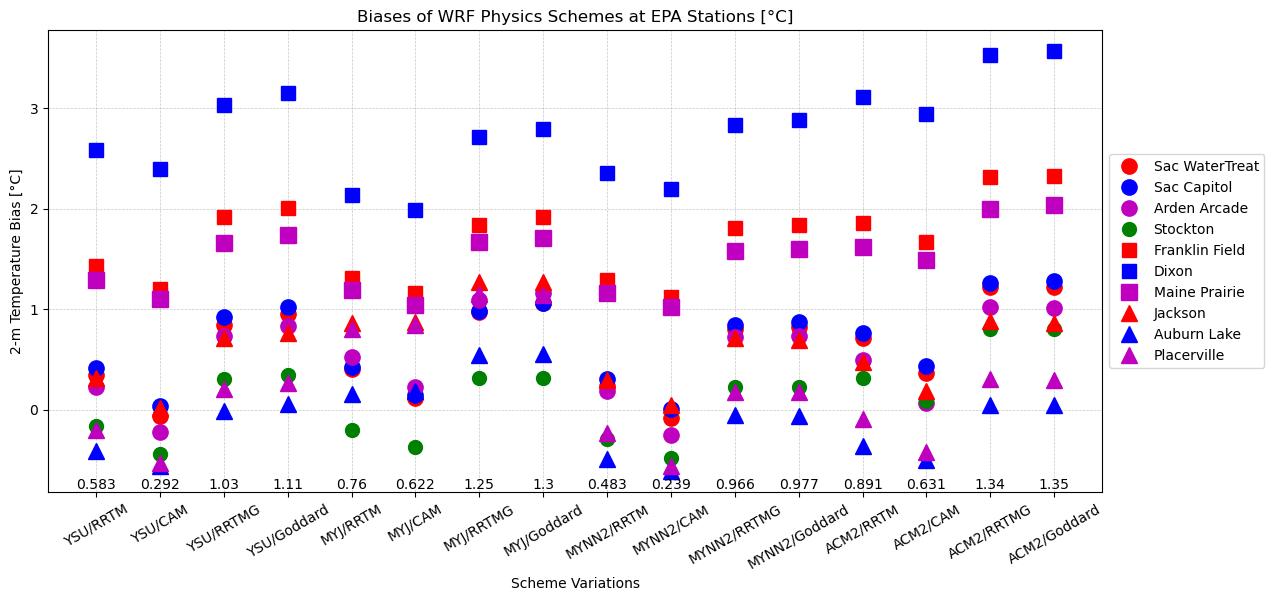

In [36]:
station_labels = [
    "Sac WaterTreat", "Sac Capitol", "Arden Arcade", "Stockton",
    "Franklin Field", "Dixon", "Maine Prairie",
    "Jackson", "Auburn Lake", "Placerville"
]
markercolors = ['or','ob','om','og','sr','sb','sm','^r','^b','^m']

plt.figure(figsize=(17, 6))

# --- Plot each station chunk with your format ---
for s in range(NStations):
    start = s * NModels
    end   = (s+1) * NModels
    plt.plot(
        range(NModels),
        MeanBias_all[s, :],
        markercolors[s],
        ms=11 if s < 3 else 10 if s < 6 else 12,
        label=station_labels[s]
    )

ax = plt.gca()

# --- Move axes left to make space for legend ---
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel("Scheme Variations")
plt.ylabel("2-m Temperature Bias [°C]")
plt.xticks(range(NModels), x_labels, rotation=30)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# --- Add bottom-axis numeric labels (model-mean RMSD) ---
MeanBias_mean = MeanBias_all.mean(axis=0)
for i, val in enumerate(MeanBias_mean):
    ax.text(i, 0.03, f"{val:.3g}", ha='center', va='top',
            transform=ax.get_xaxis_transform())

plt.title("Biases of WRF Physics Schemes at EPA Stations [°C]")
plt.show()

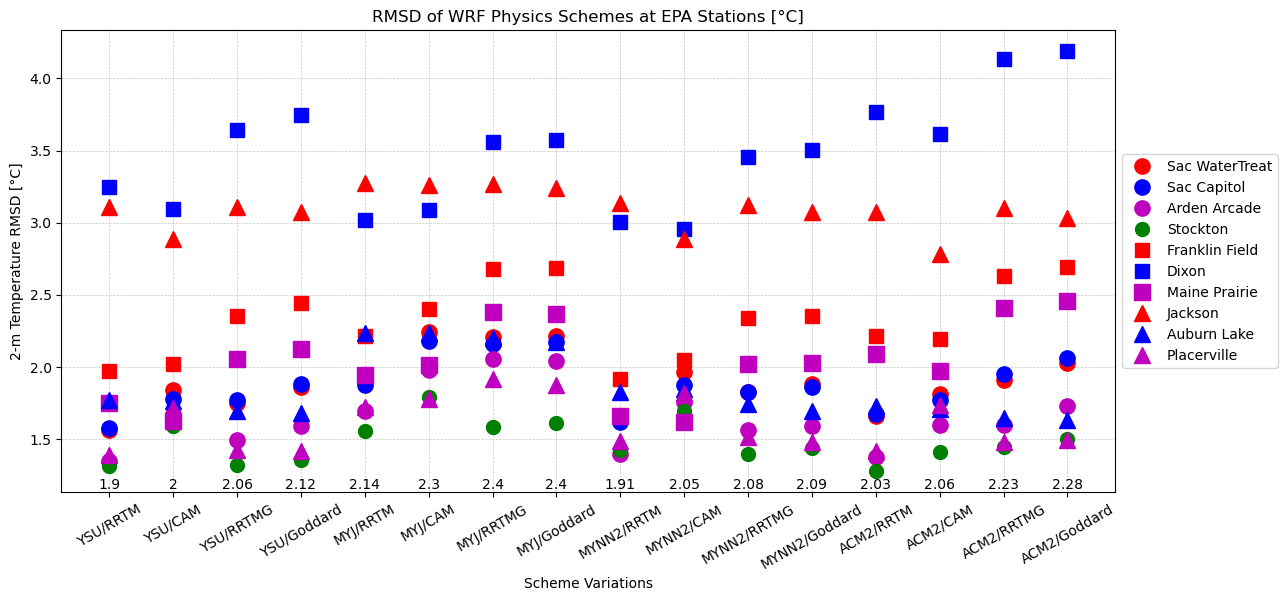

In [37]:
station_labels = [
    "Sac WaterTreat", "Sac Capitol", "Arden Arcade", "Stockton",
    "Franklin Field", "Dixon", "Maine Prairie",
    "Jackson", "Auburn Lake", "Placerville"
]
markercolors = ['or','ob','om','og','sr','sb','sm','^r','^b','^m']

plt.figure(figsize=(17, 6))

# --- Plot each station chunk with your format ---
for s in range(NStations):
    start = s * NModels
    end   = (s+1) * NModels
    plt.plot(
        range(NModels),
        RMSD_all[s, :],
        markercolors[s],
        ms=11 if s < 3 else 10 if s < 6 else 12,
        label=station_labels[s]
    )

ax = plt.gca()

# --- Move axes left to make space for legend ---
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel("Scheme Variations")
plt.ylabel("2-m Temperature RMSD [°C]")
plt.xticks(range(NModels), x_labels, rotation=30)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# --- Add bottom-axis numeric labels (model-mean RMSD) ---
Mean_RMSD = RMSD_all.mean(axis=0)
for i, val in enumerate(Mean_RMSD):
    ax.text(i, 0.03, f"{val:.3g}", ha='center', va='top',
            transform=ax.get_xaxis_transform())

plt.title("RMSD of WRF Physics Schemes at EPA Stations [°C]")
plt.show()

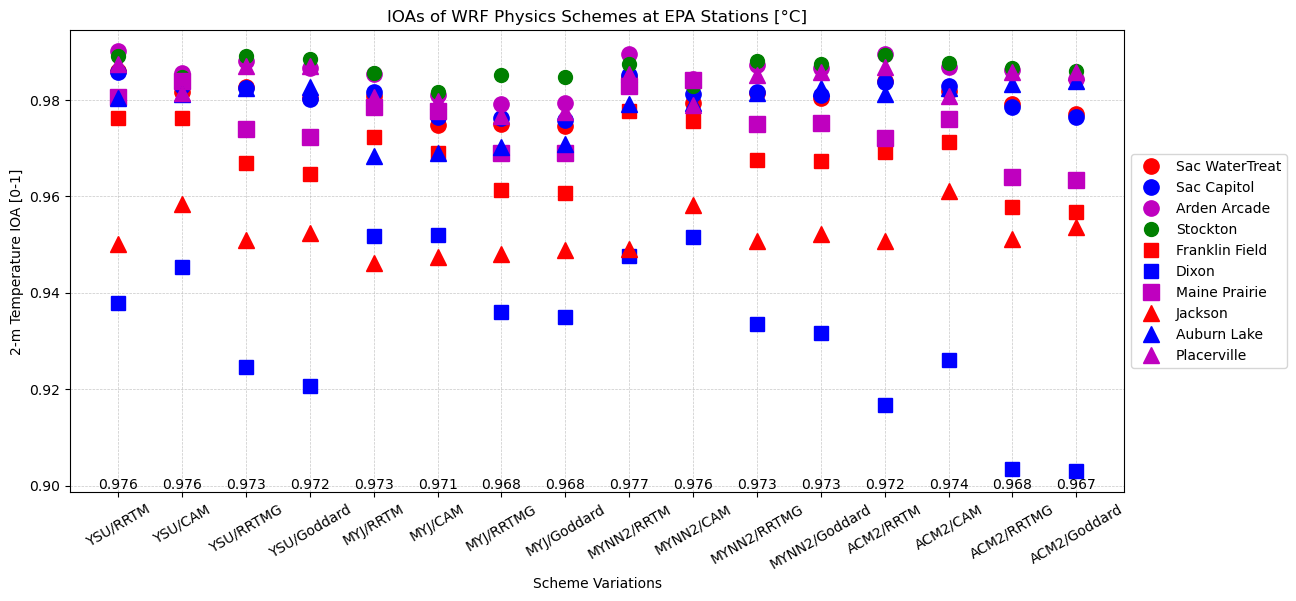

In [38]:
station_labels = [
    "Sac WaterTreat", "Sac Capitol", "Arden Arcade", "Stockton",
    "Franklin Field", "Dixon", "Maine Prairie",
    "Jackson", "Auburn Lake", "Placerville"
]
markercolors = ['or','ob','om','og','sr','sb','sm','^r','^b','^m']

plt.figure(figsize=(17, 6))

# --- Plot each station chunk with your format ---
for s in range(NStations):
    start = s * NModels
    end   = (s+1) * NModels
    plt.plot(
        range(NModels),
        IOA_all[s, :],
        markercolors[s],
        ms=11 if s < 3 else 10 if s < 6 else 12,
        label=station_labels[s]
    )

ax = plt.gca()

# --- Move axes left to make space for legend ---
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel("Scheme Variations")
plt.ylabel("2-m Temperature IOA [0-1]")
plt.xticks(range(NModels), x_labels, rotation=30)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# --- Add bottom-axis numeric labels (model-mean RMSD) ---
Mean_IOA = IOA_all.mean(axis=0)
for i, val in enumerate(Mean_IOA):
    ax.text(i, 0.03, f"{val:.3g}", ha='center', va='top',
            transform=ax.get_xaxis_transform())

plt.title("IOAs of WRF Physics Schemes at EPA Stations [°C]")
plt.show()

In [ ]:
## Loading the Libaries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Get the WRF Values for the entire month and for all 4 locations.
WRFFiles = ["/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_MP6_RAD1_251126/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_MP6_RAD3_251127/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_MP6_RAD4_250718/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_MP6_RAD5_251128/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL2_FDDA1_MP8_RAD1_251202/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL2_FDDA1_MP8_RAD3_251201/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL2_FDDA1_MP8_RAD4_250710/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL2_FDDA1_MP8_RAD5_251203/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD1_251120/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD3_251121/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD4_251118/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD5_251119/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL7_FDDA1_MP6_RAD1_251205/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL7_FDDA1_MP6_RAD3_251206/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL7_FDDA1_MP6_RAD4_251206/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL7_FDDA1_MP8_RAD5_251204/wrfout_d01_2020-06-*"]
# The x_labels should be a list of strings
x_labels = [
    "YSU/RRTM","YSU/CAM","YSU/RRTMG","YSU/Goddard",
    "MYJ/RRTM","MYJ/CAM","MYJ/RRTMG","MYJ/Goddard",
    "MYNN2/RRTM","MYNN2/CAM","MYNN2/RRTMG","MYNN2/Goddard",
    "ACM2/RRTM","ACM2/CAM","ACM2/RRTMG","ACM2/Goddard"
]
NModels=len(x_labels)
## Load the EPA Data Input File
WRFLocs= [[38.593322,-121.503795],
          [38.56844,-121.49311],
          [38.613779,-121.368014],
          [37.950741,-121.268523],
          [38.302591,-121.420838],
          [38.443056, -121.858611],
          [38.27556, -121.73667],
          [38.342606,-120.764426],
          [38.890941,-121.003373],
          [38.725282,-120.821916] ]
EPA_files = [
    "/data/wto/EPAMetData/hourly_TEMP_2020_06_Sac.csv",
    "/data/wto/EPAMetData/hourly_TEMP_2020_06_SacSoCap.csv",
    "/data/wto/EPAMetData/hourly_TEMP_2020_06_ArdenArcade.csv",
    "/data/wto/EPAMetData/hourly_TEMP_2020_06_Stockton.csv",
    "/data/wto/EPAMetData/hourly_TEMP_2020_06_Franklin.csv",
    "/data/wto/EPAMetData/hourly_TEMP_2020_06_Dixon.csv",
    "/data/wto/EPAMetData/hourly_TEMP_2020_06_MainePrairie.csv",
    "/data/wto/EPAMetData/hourly_TEMP_2020_06_Jackson.csv",
    "/data/wto/EPAMetData/hourly_TEMP_2020_06_AuburnLake.csv",
    "/data/wto/EPAMetData/hourly_TEMP_2020_06_Placerville.csv"
]
NStations=len(EPA_files)

ModelDF  = MonthGlob(WRFFiles, Var, lat_point, lon_point)
ModelNames=["YSU/Purdue","YSU/WRF1M6C","YSU/Thomp1M","YSU/Thomp2M"]
NModels=len(WRFFiles)

# Load and convert all 4 stations at once → shape (4, n_hours)
EPAVals = np.array([(np.loadtxt(f, delimiter=',', usecols=[13],max_rows=718)-32)*5/9 for f in EPA_files])

WRFVar = "T2"
WRFTime = None        # will hold the common time axis
WRFVals = []          # shape: [n_folders][n_locs][n_times]

for folder_pattern in WRFFiles:       # loop through each folder
    files = sorted(glob(folder_pattern))
    # Open all files in this folder once
    ncfiles = [Dataset(f) for f in files]

    # Concatenate all times for this variable across files
    var_all = getvar(ncfiles, WRFVar, timeidx=ALL_TIMES, method="cat")
    # var_all dims: ("Time", "south_north", "west_east")

    # Set the global time vector only once (assuming all folders have same times)
    if WRFTime is None:
        # Depending on wrf-python version, Time may be a coord or attribute
        try:
            WRFTime = to_np(var_all["Time"])
        except Exception:
            WRFTime = to_np(var_all.Time)

    # Compute the (x, y) indices for each requested lat/lon ONCE per folder
    loc_indices = []
    first_ds = ncfiles[0]
    for lat, lon in WRFLocs:
        x_idx, y_idx = ll_to_xy(first_ds, lat, lon, as_int=True)
        loc_indices.append((x_idx, y_idx))

    # Extract timeseries for each location
    folder_vals = []   # [n_locs][n_times]
    for (x_idx, y_idx) in loc_indices:
        # var_all: [time, y, x]
        series_K = var_all[:, y_idx, x_idx]
        series_C = to_np(series_K - 273.15)   # convert to °C
        folder_vals.append(series_C)

    WRFVals.append(folder_vals)

    # Close datasets to free resources
    for ds in ncfiles:
        ds.close()

WRFVals = np.array(WRFVals)
WRFTime = np.array(WRFTime)

print(len(EPAVals),len(WRFVals), len(WRFTime))
print(EPAVals.shape,WRFVals.shape,WRFTime.shape)

Biases = []
BiasesMean = []
BiasesRMSD = []
RMSDs = []
RMSDsMean = []
RMSDsRMSD = []
IOAs = []
IOAsMean = []
IOAsRMSD = []
for iLoc in range(0,EPAVals.shape[0]):
    for iScheme in range(0,WRFVals.shape[0]):
        Diff = WRFVals[iScheme,iLoc]-EPAVals[iLoc]
        Biases.append(np.mean(Diff))
        RMSDs.append(np.sqrt(np.mean(Diff**2)))
        # Calculate Index of Agreement. (Willmott 1981)
        numerator = np.sum((WRFVals[iScheme,iLoc]-EPAVals[iLoc]) ** 2)
        denominator = np.sum((np.abs(WRFVals[iScheme,iLoc] - np.mean(EPAVals[iLoc])) + np.abs(EPAVals[iLoc] - np.mean(EPAVals[iLoc]))) ** 2)
        ioa = 1 - numerator / denominator if denominator != 0 else np.nan
        IOAs.append(ioa)
Biases=np.array(Biases)
RMSDs=np.array(RMSDs)
IOAs=np.array(IOAs)

for iModel in range(NModels):
    ModelBiases=Biases[iModel::20]
    BiasesMean.append(np.mean(ModelBiases))
    BiasesRMSD.append(np.sqrt(np.mean(ModelBiases**2))/NStations)
    ModelRMSDs=RMSDs[iModel::20]
    RMSDsMean.append(np.mean(ModelRMSDs))
    RMSDsRMSD.append(np.sqrt(np.mean(ModelRMSDs**2))/NStations)
    ModelIOAs=IOAs[iModel::20]
    IOAsMean.append(np.mean(ModelIOAs))
    IOAsRMSD.append(np.sqrt(np.mean(ModelIOAs**2))/NStations)

                      
plt.figure(figsize=(16, 6))
#plt.errorbar(range(0,NModels), BiasesMean, yerr=BiasesRMSD, fmt='k*', ms=14, capsize=8)
plt.plot(Biases[0:NModels*1],'or',ms=11,label="Sac WaterTreat")
plt.plot(Biases[NModels*1:NModels*2],'ob',ms=11,label="Sac Capitol")
plt.plot(Biases[NModels*2:NModels*3],'om',ms=11,label="Arden Arcade")
plt.plot(Biases[NModels*3:NModels*4],'sr',ms=10,label="Franklin Field")
plt.plot(Biases[NModels*4:NModels*5],'sb',ms=10,label="Colusa")
plt.plot(Biases[NModels*5:NModels*6],'sm',ms=10,label="Carbona")
plt.plot(Biases[NModels*6:NModels*7],'^r',ms=12,label="Jackson")
plt.plot(Biases[NModels*7:NModels*8],'^b',ms=12,label="Auburn Lake")
plt.plot(Biases[NModels*8:NModels*9],'^m',ms=12,label="Diamond Springs")
plt.plot(Biases[NModels*9:NModels*10],'^g',ms=12,label="San Andreas")


ax=plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Scheme Variations")
plt.ylabel("2-m Temperature Mean Bias [K]")
plt.xticks(range(0,NModels), x_labels,rotation=60)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
# Instead of plotting points, put the y-values as text above the x-axis
for i, val in enumerate(BiasesMean):
    ax.text( i, 0.03, f"{val:.3g}", ha='center', va='top', transform=ax.get_xaxis_transform())
plt.show()
#print(Biases)

plt.figure(figsize=(16, 6))
#plt.errorbar(range(0,NModels), RMSDsMean, yerr=RMSDsRMSD, fmt='k*', ms=14, capsize=8)
plt.plot(RMSDs[0:NModels*1],'or',ms=11,label="Sac WaterTreat")
plt.plot(RMSDs[NModels*1:NModels*2],'ob',ms=11,label="Sac Capitol")
plt.plot(RMSDs[NModels*2:NModels*3],'om',ms=11,label="Arden Arcade")
plt.plot(RMSDs[NModels*3:NModels*4],'sr',ms=10,label="Franklin Field")
plt.plot(RMSDs[NModels*4:NModels*5],'sb',ms=10,label="Colusa")
plt.plot(RMSDs[NModels*5:NModels*6],'sm',ms=10,label="Carbona")
plt.plot(RMSDs[NModels*6:NModels*7],'^r',ms=12,label="Jackson")
plt.plot(RMSDs[NModels*7:NModels*8],'^b',ms=12,label="Auburn Lake")
plt.plot(RMSDs[NModels*8:NModels*9],'^m',ms=12,label="Diamond Springs")
plt.plot(RMSDs[NModels*9:NModels*10],'^g',ms=12,label="San Andreas")
ax=plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Scheme Variations")
plt.ylabel("2-m Temperature RMSD [K]")
plt.xticks(range(0,NModels), x_labels,rotation=60)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
# Instead of plotting points, put the y-values as text above the x-axis
for i, val in enumerate(RMSDsMean):
    ax.text( i, 0.03, f"{val:.3g}", ha='center', va='top', transform=ax.get_xaxis_transform())
plt.show()
#print(RMSDs)

plt.figure(figsize=(16, 6))
#plt.errorbar(range(0,NModels), IOAsMean, yerr=IOAsRMSD, fmt='k*', ms=14, capsize=8)
plt.plot(IOAs[0:NModels*1],'or',ms=11,label="Sac WaterTreat")
plt.plot(IOAs[NModels*1:NModels*2],'ob',ms=11,label="Sac Capitol")
plt.plot(IOAs[NModels*2:NModels*3],'om',ms=11,label="Arden Arcade")
plt.plot(IOAs[NModels*3:NModels*4],'sr',ms=10,label="Franklin Field")
plt.plot(IOAs[NModels*4:NModels*5],'sb',ms=10,label="Colusa")
plt.plot(IOAs[NModels*5:NModels*6],'sm',ms=10,label="Carbona")
plt.plot(IOAs[NModels*6:NModels*7],'^r',ms=12,label="Jackson")
plt.plot(IOAs[NModels*7:NModels*8],'^b',ms=12,label="Auburn Lake")
plt.plot(IOAs[NModels*8:NModels*9],'^m',ms=12,label="Diamond Springs")
plt.plot(IOAs[NModels*9:NModels*10],'^g',ms=12,label="San Andreas")
ax=plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Scheme Variations")
plt.ylabel("2-m Temperature IOA [0-1]")
plt.xticks(range(0,NModels), x_labels,rotation=60)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
# Instead of plotting points, put the y-values as text above the x-axis
for i, val in enumerate(IOAsMean):
    ax.text( i, 0.03, f"{val:.3g}", ha='center', va='top', transform=ax.get_xaxis_transform())
plt.show()
#print(IOAs)

In [ ]:
Biases = []
BiasesMean = []
BiasesRMSD = []
RMSDs = []
RMSDsMean = []
RMSDsRMSD = []
IOAs = []
IOAsMean = []
IOAsRMSD = []
for iLoc in range(0,EPAVals.shape[0]):
    for iScheme in range(0,WRFVals.shape[0]):
        Diff = WRFVals[iScheme,iLoc]-EPAVals[iLoc]
        Biases.append(np.mean(Diff))
        RMSDs.append(np.sqrt(np.mean(Diff**2)))
        # Calculate Index of Agreement. (Willmott 1981)
        numerator = np.sum((WRFVals[iScheme,iLoc]-EPAVals[iLoc]) ** 2)
        denominator = np.sum((np.abs(WRFVals[iScheme,iLoc] - np.mean(EPAVals[iLoc])) + np.abs(EPAVals[iLoc] - np.mean(EPAVals[iLoc]))) ** 2)
        ioa = 1 - numerator / denominator if denominator != 0 else np.nan
        IOAs.append(ioa)
Biases=np.array(Biases)
RMSDs=np.array(RMSDs)
IOAs=np.array(IOAs)

for iModel in range(NModels):
    ModelBiases=Biases[iModel::20]
    BiasesMean.append(np.mean(ModelBiases))
    BiasesRMSD.append(np.sqrt(np.mean(ModelBiases**2))/NStations)
    ModelRMSDs=RMSDs[iModel::20]
    RMSDsMean.append(np.mean(ModelRMSDs))
    RMSDsRMSD.append(np.sqrt(np.mean(ModelRMSDs**2))/NStations)
    ModelIOAs=IOAs[iModel::20]
    IOAsMean.append(np.mean(ModelIOAs))
    IOAsRMSD.append(np.sqrt(np.mean(ModelIOAs**2))/NStations)

                      
plt.figure(figsize=(16, 6))
#plt.errorbar(range(0,NModels), BiasesMean, yerr=BiasesRMSD, fmt='k*', ms=14, capsize=8)
plt.plot(Biases[0:NModels*1],'or',ms=11,label="Sac WaterTreat")
plt.plot(Biases[NModels*1:NModels*2],'ob',ms=11,label="Sac Capitol")
plt.plot(Biases[NModels*2:NModels*3],'om',ms=11,label="Arden Arcade")
plt.plot(Biases[NModels*3:NModels*4],'sr',ms=10,label="Franklin Field")
plt.plot(Biases[NModels*4:NModels*5],'sb',ms=10,label="Colusa")
plt.plot(Biases[NModels*5:NModels*6],'sm',ms=10,label="Carbona")
plt.plot(Biases[NModels*6:NModels*7],'^r',ms=12,label="Jackson")
plt.plot(Biases[NModels*7:NModels*8],'^b',ms=12,label="Auburn Lake")
plt.plot(Biases[NModels*8:NModels*9],'^m',ms=12,label="Diamond Springs")
plt.plot(Biases[NModels*9:NModels*10],'^g',ms=12,label="San Andreas")


ax=plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Scheme Variations")
plt.ylabel("2-m Temperature Mean Bias [K]")
plt.xticks(range(0,NModels), x_labels,rotation=60)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
# Instead of plotting points, put the y-values as text above the x-axis
for i, val in enumerate(BiasesMean):
    ax.text( i, 0.03, f"{val:.3g}", ha='center', va='top', transform=ax.get_xaxis_transform())
plt.show()
#print(Biases)

plt.figure(figsize=(16, 6))
#plt.errorbar(range(0,NModels), RMSDsMean, yerr=RMSDsRMSD, fmt='k*', ms=14, capsize=8)
plt.plot(RMSDs[0:NModels*1],'or',ms=11,label="Sac WaterTreat")
plt.plot(RMSDs[NModels*1:NModels*2],'ob',ms=11,label="Sac Capitol")
plt.plot(RMSDs[NModels*2:NModels*3],'om',ms=11,label="Arden Arcade")
plt.plot(RMSDs[NModels*3:NModels*4],'sr',ms=10,label="Franklin Field")
plt.plot(RMSDs[NModels*4:NModels*5],'sb',ms=10,label="Colusa")
plt.plot(RMSDs[NModels*5:NModels*6],'sm',ms=10,label="Carbona")
plt.plot(RMSDs[NModels*6:NModels*7],'^r',ms=12,label="Jackson")
plt.plot(RMSDs[NModels*7:NModels*8],'^b',ms=12,label="Auburn Lake")
plt.plot(RMSDs[NModels*8:NModels*9],'^m',ms=12,label="Diamond Springs")
plt.plot(RMSDs[NModels*9:NModels*10],'^g',ms=12,label="San Andreas")
ax=plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Scheme Variations")
plt.ylabel("2-m Temperature RMSD [K]")
plt.xticks(range(0,NModels), x_labels,rotation=60)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
# Instead of plotting points, put the y-values as text above the x-axis
for i, val in enumerate(RMSDsMean):
    ax.text( i, 0.03, f"{val:.3g}", ha='center', va='top', transform=ax.get_xaxis_transform())
plt.show()
#print(RMSDs)

plt.figure(figsize=(16, 6))
#plt.errorbar(range(0,NModels), IOAsMean, yerr=IOAsRMSD, fmt='k*', ms=14, capsize=8)
plt.plot(IOAs[0:NModels*1],'or',ms=11,label="Sac WaterTreat")
plt.plot(IOAs[NModels*1:NModels*2],'ob',ms=11,label="Sac Capitol")
plt.plot(IOAs[NModels*2:NModels*3],'om',ms=11,label="Arden Arcade")
plt.plot(IOAs[NModels*3:NModels*4],'sr',ms=10,label="Franklin Field")
plt.plot(IOAs[NModels*4:NModels*5],'sb',ms=10,label="Colusa")
plt.plot(IOAs[NModels*5:NModels*6],'sm',ms=10,label="Carbona")
plt.plot(IOAs[NModels*6:NModels*7],'^r',ms=12,label="Jackson")
plt.plot(IOAs[NModels*7:NModels*8],'^b',ms=12,label="Auburn Lake")
plt.plot(IOAs[NModels*8:NModels*9],'^m',ms=12,label="Diamond Springs")
plt.plot(IOAs[NModels*9:NModels*10],'^g',ms=12,label="San Andreas")
ax=plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Scheme Variations")
plt.ylabel("2-m Temperature IOA [0-1]")
plt.xticks(range(0,NModels), x_labels,rotation=60)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
# Instead of plotting points, put the y-values as text above the x-axis
for i, val in enumerate(IOAsMean):
    ax.text( i, 0.03, f"{val:.3g}", ha='center', va='top', transform=ax.get_xaxis_transform())
plt.show()
#print(IOAs)